Results for Emails.csv:
╒═══════════╤═════════╕
│ Sector    │  Count  │
╞═══════════╪═════════╡
│ finance   │   625   │
├───────────┼─────────┤
│ online    │   299   │
├───────────┼─────────┤
│ gov       │   933   │
├───────────┼─────────┤
│ health    │   445   │
├───────────┼─────────┤
│ tech      │   994   │
├───────────┼─────────┤
│ education │  1256   │
├───────────┼─────────┤
│ travel    │   498   │
├───────────┼─────────┤
│ job       │  1332   │
├───────────┼─────────┤
│ shopping  │   986   │
├───────────┼─────────┤
│ social    │   608   │
╘═══════════╧═════════╛


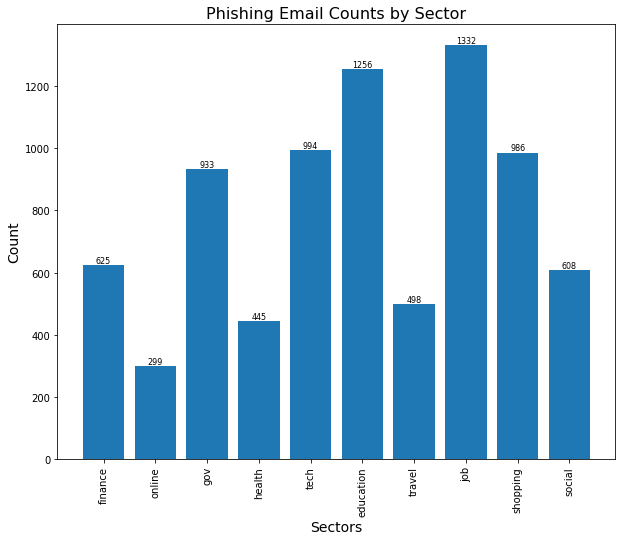

Results for phishing_data_by_type.csv:
╒═══════════╤═════════╕
│ Sector    │  Count  │
╞═══════════╪═════════╡
│ finance   │   28    │
├───────────┼─────────┤
│ online    │   25    │
├───────────┼─────────┤
│ gov       │   35    │
├───────────┼─────────┤
│ health    │   15    │
├───────────┼─────────┤
│ tech      │   15    │
├───────────┼─────────┤
│ education │    9    │
├───────────┼─────────┤
│ travel    │   13    │
├───────────┼─────────┤
│ job       │   16    │
├───────────┼─────────┤
│ shopping  │   40    │
├───────────┼─────────┤
│ social    │   19    │
╘═══════════╧═════════╛


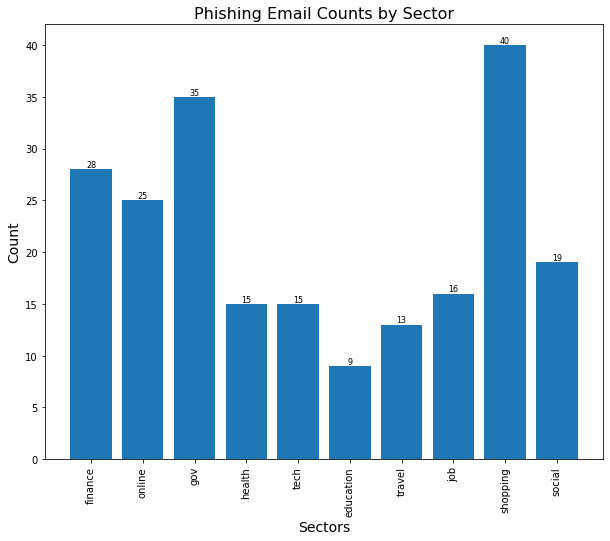

Results for Phishing_Email.csv:
╒═══════════╤═════════╕
│ Sector    │  Count  │
╞═══════════╪═════════╡
│ finance   │  1529   │
├───────────┼─────────┤
│ online    │  1238   │
├───────────┼─────────┤
│ gov       │  2363   │
├───────────┼─────────┤
│ health    │  1372   │
├───────────┼─────────┤
│ tech      │  3400   │
├───────────┼─────────┤
│ education │  3334   │
├───────────┼─────────┤
│ travel    │  1005   │
├───────────┼─────────┤
│ job       │  2350   │
├───────────┼─────────┤
│ shopping  │  3713   │
├───────────┼─────────┤
│ social    │  2170   │
╘═══════════╧═════════╛


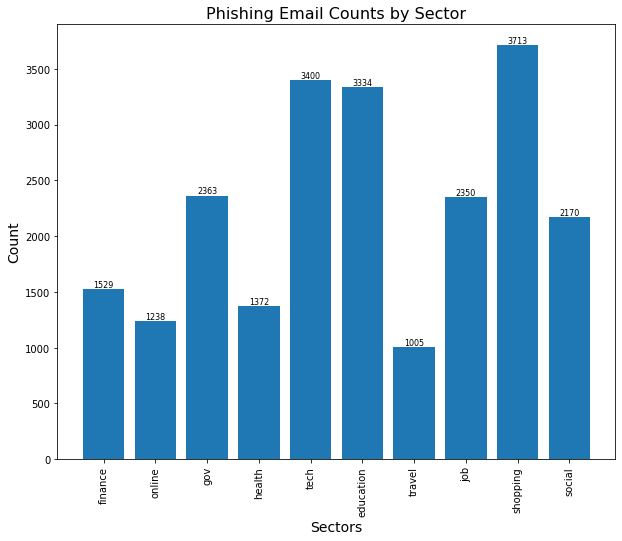

Results for sms_messaging.csv:
╒═══════════╤═════════╕
│ Sector    │  Count  │
╞═══════════╪═════════╡
│ finance   │    6    │
├───────────┼─────────┤
│ online    │   39    │
├───────────┼─────────┤
│ gov       │   26    │
├───────────┼─────────┤
│ health    │   16    │
├───────────┼─────────┤
│ tech      │   47    │
├───────────┼─────────┤
│ education │   117   │
├───────────┼─────────┤
│ travel    │   69    │
├───────────┼─────────┤
│ job       │   58    │
├───────────┼─────────┤
│ shopping  │   146   │
├───────────┼─────────┤
│ social    │   118   │
╘═══════════╧═════════╛


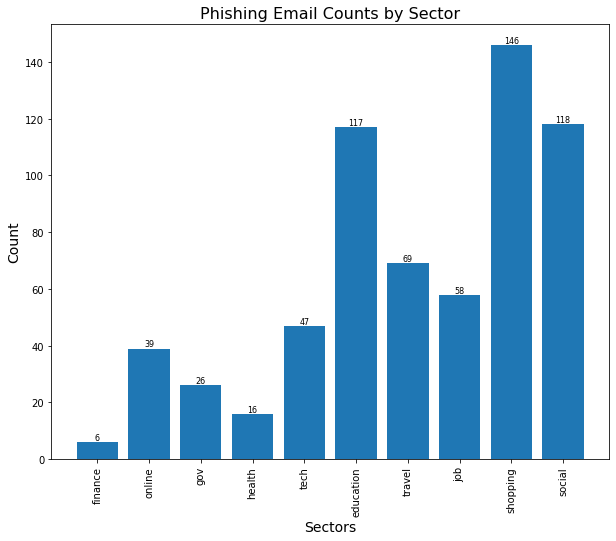

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tabulate import tabulate
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def process_dataset(file_path, all_keywords):
    try:
        df = pd.read_csv(file_path)

        # Print the columns present in the DataFrame
        print(f"Columns in DataFrame of '{file_path}': {df.columns}")

        # Check if the specified column exists in the DataFrame
        if "Type" in df.columns:
            df = df.loc[df["Type"] != "False Positives "]

            # Check if 'Subject' and 'Text' columns exist in the DataFrame
            if "Subject" in df.columns and "Text" in df.columns:
                dataset = np.array(df["Subject"] + " " + df["Text"])
                return dataset
            else:
                print(f"Columns 'Subject' or 'Text' not found in the DataFrame of '{file_path}'.")
                return np.array([])
        else:
            print(f"Column 'Type' not found in the DataFrame of '{file_path}'.")
            return np.array([])
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return np.array([])

def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

def keyword_search(sector, keywords, data):
    count = 0
    emails, labels = [], []

    pattern = "|".join(map(re.escape, keywords))
    pattern = r"\b({})\b".format(pattern)

    for index, email in enumerate(data, start=1):
        matches = re.findall(pattern, email)

        if matches:
            emails.append(email)
            labels.append(sector)
            count += 1

    return count, emails, labels

def visualize_sector_counts(labels):
    counts = Counter(labels)
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Sectors')
    plt.ylabel('Count')
    plt.title('Phishing Email Counts by Sector')
    plt.show()

def create_keyword_table(*keyword_lists):
    max_len = max(len(lst) for lst in keyword_lists)
    keyword_lists_padded = [lst + [''] * (max_len - len(lst)) for lst in keyword_lists]
    col_labels = ["Financial Sector", "Online Services Sector", "Government Sector", "Healthcare Sector"]
    table = tabulate(keyword_lists_padded, headers=col_labels, tablefmt="fancy_grid", numalign="center")
    return table

def perform_clustering(X, n_clusters=4):
    # Create a TF-IDF vectorizer to convert text data into numerical features
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(X)

    n_clusters = 4

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    X_clusters = kmeans.fit_predict(X_tfidf)

    # Create an array to store the total TF-IDF values for each word in each cluster
    cluster_word_tfidf_sums = []

    for cluster_id in range(n_clusters):
        # Select the emails that belong to the current cluster
        cluster_indices = [i for i, cluster in enumerate(X_clusters) if cluster == cluster_id]

        # Create a submatrix containing only the emails in this cluster
        cluster_submatrix = X_tfidf[cluster_indices]

        # Sum the TF-IDF values for each word across all emails in the cluster
        word_tfidf_sums = np.array(cluster_submatrix.sum(axis=0))[0]

        # Get the feature names (words) from the TF-IDF vectorizer
        feature_names = tfidf_vectorizer.get_feature_names_out() if hasattr(tfidf_vectorizer, 'get_feature_names_out') else tfidf_vectorizer.get_feature_names()

        # Create a list of (word, total TF-IDF) pairs
        cluster_word_tfidf_sums.append(list(zip(feature_names, word_tfidf_sums)))

    # Print the most common words for each cluster
    N = 10
    for cluster_id, word_tfidf_sums in enumerate(cluster_word_tfidf_sums):
        print(f"Cluster {cluster_id} - Most common words:")
        sorted_words = sorted(word_tfidf_sums, key=lambda x: x[1], reverse=True)
        for word, tfidf_sum in sorted_words[:N]:
            print(f"{word}: {tfidf_sum:.3f}")

    df = pd.read_csv(file_path)
    df = df.loc[df["Type"] != "False Positives "]

    dataset = np.array(df["Subject"] + " " + df["Text"])
    data = [clean_text(text) for text in dataset]

    sector_counts = {}
    for sector, keywords in sector_keywords.items():
        count, _, _ = keyword_search(sector, keywords, data)
        sector_counts[sector] = count

    return sector_counts

def process_dataset(file_path, all_keywords, email_delimiter=None):
    try:
        df = pd.read_csv(file_path)

        # Check if the specified column exists in the DataFrame
        type_column = None
        if 'Type' in df.columns:
            type_column = 'Type'
        elif 'type' in df.columns:
            type_column = 'type'

        if type_column is not None:
            # Filter out "False Positives" in the specified 'Type' column
            df = df.loc[df[type_column] != "False Positives "]

        # Combine available columns using the specified delimiter or the default space
        if "Subject" in df.columns and "Text" in df.columns:
            if email_delimiter:
                dataset = np.array(df["Subject"] + email_delimiter + df["Text"])
            else:
                dataset = np.array(df["Subject"] + " " + df["Text"])
        else:
            # If neither 'Subject' nor 'Text' columns are present, use the entire row as the dataset
            dataset = np.array(df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1))

        data = [clean_text(text) for text in dataset]

        sector_counts = {}
        for sector, keywords in all_keywords.items():
            count, _, _ = keyword_search(sector, keywords, data)
            sector_counts[sector] = count

        return sector_counts

    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return {}

def visualize_sector_counts(labels):
    counts = Counter(labels)

    # Increase the figure size
    fig, ax = plt.subplots(figsize=(10, 8))

    bars = ax.bar(counts.keys(), counts.values())

    # Add labels to the bars with adjusted font size
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Sectors', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title('Phishing Email Counts by Sector', fontsize=16)

    # Explicitly set rotation angle for x-axis labels
    plt.xticks(rotation=90)

    plt.show()

def create_sector_table(sector_counts):
    table = tabulate(sector_counts.items(), headers=['Sector', 'Count'], tablefmt="fancy_grid", numalign="center")
    print(table)

def process_datasets_in_folder(folder_path, all_keywords, email_delimiter=None):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            
            if os.path.isfile(file_path):
                sector_counts = process_dataset(file_path, all_keywords, email_delimiter)
                
                print(f"Results for {file_name}:")
                create_sector_table(sector_counts)
                visualize_sector_counts(sector_counts)

                # You can perform additional analysis or visualization here if needed

if __name__ == "__main__":
    folder_path = "datasets"
    
    all_keywords = {
        "finance": ["banking", "credit card", "wire transfer", "investment", "financial", "atm"],
        "online": ["social media", "privacy policy", "subscription", "online shopping", "online gaming", "tech", "free trial", "product recall", "friend request", "profile update", "order confirmation", "discounts", "discount", "return policy", "exchange policy", "shopping cart", "software updates", "software update", "device", "game", "customer feedback", "gift card"],
        "gov": ["government", "job opportunities", "job opportunity", "legal", "nonprofit", "scholarships", "financial aid", "grants", "grant", "social security", "workplace", "campus", "tuition", "transcripts", "transcript", "academic", "student loans", "student loan", "fundraising", "volunteer", "donation", "court", "criminal", "crime", "law", "jury", "payroll", "employee", "vote", "public service", "passport renewal"],
        "health": ["healthcare", "health", "pharmacy", "covid", "covid-19", "medicine", "medical", "medication", "medicare", "patient", "electricity", "utility", "travel", "airline"],
        "tech": ["technology", "software", "hardware", "data breach", "cybersecurity", "hack", "data privacy", "internet", "network", "IT support", "digital", "cloud computing", "AI", "machine learning", "automation", "programming", "coding"],
        "education": ["education", "school", "university", "college", "class", "course", "scholarship", "study", "academic", "student", "teacher", "learning", "online education", "coursework", "exam", "graduation"],
        "travel": ["travel", "vacation", "flight", "hotel", "tour", "booking", "holiday", "destination", "cruise"],
        "job": ["job", "career", "employment", "resume", "interview", "hiring", "opportunity", "position"],
        "shopping": ["shopping", "sale", "discount", "offer", "deal", "purchase", "buy", "shopping cart", "online store"],
        "social": ["social", "friends", "network", "invitation", "event", "connect", "community", "friendship"]
    }

    process_datasets_in_folder(folder_path, all_keywords, email_delimiter='\n')